<a href="https://colab.research.google.com/gist/worona-upb/f01148ab8bec5f24a45eadb121faff17/02_data_preparation_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
SEED = 1

# Config

## Online

Das Notebook kann mit unserem vollständigen finalen Modell online auf https://colab.research.google.com und dem [Google-Drive-Ordner](https://drive.google.com/drive/folders/1uGUhBHv95S7T_YHfX-radjUapn1B5GHb?usp=sharing) ("Add to My Drive"/"Zu Meine Ablage hinzufügen" erforderlich) ausgeführt werden. Dabei werden die Modelle aus dem Drive-Ordner geladen.

- Im Google Colab Notebook steht außerdem eine GPU über "Runtime" -> "Change runtime type" zur Verfügung

## Lokal

Ansonsten muss zuvor das Notebook `01_Data_Understanding` ausgeführt worden sein und folgende Konfigurationsparameter angepasst werden:

- `dataset_folder_name`: Ordner, der den Yelp-Datensatz (.csv) enthält
    - Benötigt werden die Tabellen "category", "business" und "review"
- `table_name_template`: Dateinamenformat der .csv-Dateien
    - `{table_name}` wird in der Funktion `load_table` durch den jeweiligen Tabellennamen ersetzt
- `spacy_model`: SpaCy-Modell-Größe
- `sample_size`: Anzahl zu verarbeitender Reviews
- `lda_config`: LDA-Modell-Konfiguration
- `cpu_cores`: Anzahl CPU-Kerne

In [0]:
dataset_folder_name = "yelp_data"
table_name_template = "yelp_db_{table_name}.csv"

# spacy_model = "en_core_web_md" #  91 MB
spacy_model = "en_core_web_lg" # 789 MB

sample_size = 50_000

lda_demo_config = {
    "num_topics": 15,
    "alpha": "auto",
    "eta": "auto",
    "random_state": SEED
}

# Tatsächliche verwendete Config
lda_default_config = {
    "num_topics": 40,
    "chunksize": 4000,
    "passes": 40,
    "iterations": 400,
    "eval_every": None,
    "random_state": SEED
}

# lda_config = lda_demo_config
lda_config = lda_default_config

# (In Google Colab ist 1 CPU-Kern verfügbar)
cpu_cores = 1

Für den Umgang mit den verschiedenen Python-Bibliotheken haben wir uns vor an dem Notebook
[Modern NLP in Python, 2019](https://github.com/skipgram/modern-nlp-in-python-2019/blob/master/notebooks/Modern_NLP_in_Python.ipynb) und den Tutorials
der [SpaCy](https://spacy.io/)-, [Gensim](https://radimrehurek.com/gensim/auto_examples/) und [Pandas](https://pandas.pydata.org/docs/)-Dokumentationen orientiert.

# Imports und Dependencys

In [0]:
import re
import shutil

# Verfügbarkeit von Nvidia CUDA überprüfen
CUDA_VERSION = None
if shutil.which("nvcc") is not None:
    _cuda_v_cmd = !nvcc --version
    _cuda_v_match = re.search(r"release (\d\d?)\.(\d)", _cuda_v_cmd.n, re.MULTILINE)

    if _cuda_v_match:
        _cuda_v_major, _cuda_v_minor = _cuda_v_match.groups()
        if _cuda_v_major == "9":
            if _cuda_v_minor in ("1", "2"):
                CUDA_VERSION = _cuda_v_major + _cuda_v_minor
            else:
                CUDA_VERSION = "90"
        elif _cuda_v_major == "10":
            CUDA_VERSION = "100"

# Google Colab prüfen
try:
    INSIDE_COLAB = get_ipython().config.IPKernelApp.kernel_class == "google.colab._kernel.Kernel"
except Exception:
    INSIDE_COLAB = False

In [0]:
!pip install -U tqdm gensim
!pip install matplotlib pyldavis numpy pandas fastparquet seaborn sklearn nltk

if CUDA_VERSION:
    !pip install spacy[cuda$CUDA_VERSION]
else:
    !pip install spacy

!pip install spacy-langdetect

if INSIDE_COLAB:
    !pip install google-colab
    %load_ext google.colab.data_table

In [0]:
from sklearn.feature_extraction.text import CountVectorizer
from collections import defaultdict
from datetime import date
from functools import lru_cache
import importlib
from itertools import islice
import os
from pprint import pprint
import textwrap
import warnings
warnings.filterwarnings("ignore")

In [0]:
from gensim.models.word2vec import LineSentence
from gensim.models.phrases import Phrases, Phraser
from gensim.corpora import Dictionary, MmCorpus
from gensim.models import LdaModel, LdaMulticore

if cpu_cores > 1:
    lda_model_class = LdaMulticore
    lda_config["workers"] = cpu_cores - 1
else:
    lda_model_class = LdaModel


import matplotlib
import matplotlib.pyplot as plt

import seaborn as sns
sns.set(style="darkgrid")

import pyLDAvis
import pyLDAvis.gensim

import numpy as np
import pandas as pd

import spacy
from spacy_langdetect import LanguageDetector
print("GPU:", spacy.prefer_gpu())

from tqdm.auto import tqdm
tqdm.pandas()

if INSIDE_COLAB:
    from google.colab import data_table
    data_table.DataTable.num_rows_per_page = 40

from IPython.display import HTML

In [0]:
if INSIDE_COLAB:
    mount_directory = "/gdrive"
    dataset_directory = os.path.join(mount_directory, "My Drive", dataset_folder_name)
else:
    dataset_directory = dataset_folder_name


def p(*path):
    """Utility function to create a path to dataset directory."""

    return os.path.join(dataset_directory, *path)


review_csv_kwargs = {
    "parse_dates": [2],
    "infer_datetime_format": True
}

def load_table(table_name):
    """Load a yelp database table by its name."""

    kwargs = review_csv_kwargs if table_name == "review" else {}

    return pd.read_csv(
        p(table_name_template.format(table_name=table_name)),
        **kwargs
    )


class PATHS:
    """Collections of paths used in this notebook."""

    food_reviews = p("yelp_db_review_food.parquet")
    parsed_food_reviews = p("yelp_db_review_parsed.parquet")

    bigram_model = p("yelp_reviews_bigram_phrase_model")
    trigram_model = p("yelp_reviews_trigram_phrase_model")

    dictionary = p("yelp_reviews_dictionary.dict")

    bow = p("yelp_reviews_bow.mm")

    lda = p("yelp_reviews_lda_model_40_40")
    ldavis = p("yelp_reviews_ldavis_40_40.html")

    topic_matrix = p("yelp_reviews_topic_matrix.parquet")
    topic_matrix_norm = p("yelp_reviews_topic_matrix_norm.parquet")
    topic_matrix_norm_stars = p("yelp_reviews_topic_matrix_norm_stars.parquet")


def save_parquet(df, path):
    """Save a dataframe in parquet format."""

    print(f"Speichere {path!r}...")
    df.to_parquet(path, engine="fastparquet", index=True, compression="gzip")

def load_parquet(path):
    """Load a dataframe in parquet format."""

    print(f"Lade {path!r}...")
    return pd.read_parquet(path, engine="fastparquet")

In [0]:
if INSIDE_COLAB:
    from google.colab import drive
    drive.mount(mount_directory)

# Texte verarbeiten

In [0]:
# Bestehende verarbeitete Reviews erweitern (True) oder vorhandene laden (False)
update_parsed_reviews = False

execute_nlp = not os.path.exists(PATHS.parsed_food_reviews) or update_parsed_reviews

## SpaCy-Modell herunterladen

In [0]:
def download_spacy_model():
    """Download the spacy model."""

    !python -m spacy download $spacy_model

In [0]:
if execute_nlp:
    download_spacy_model()

In [0]:
def load_spacy_model():
    """Load the spacy model."""

    if importlib.util.find_spec(spacy_model) is None:
        download_spacy_model()

    return importlib.import_module(spacy_model).load()

## Text normalisieren

In [0]:
def check_is_punct(token):
    """Returns True if a token consists of punctuation of space characters."""

    return token.is_punct or token.is_space

def check_is_stop(token):
    """Returns True if a token is a stopword."""

    return token.is_stop

def check_is_special(token):
    """Returns True if a token contains special characters."""
    return not token.is_alpha

def to_lemma(token, keep_pronoun=True):
    """
    Returns the lemma of a token,
    None if the token is a pronoun and keep_pronoun is False.
    """

    lemm = token.lemma_

    if lemm == "-PRON-":
        return token.lower_ if keep_pronoun else None

    return lemm.lower()

def _to_text(token):
    return token.text

def normalize_document(doc, *skip_predicates, token_transformer=_to_text):
    """
    Normalize a document, skipping all tokens for which any of the passed
    check functions returns True.
    """

    sents = []

    for sent in doc.sents:
        toks = []

        for tok in sent:
            if any(pred(tok) for pred in skip_predicates):
                continue

            tok = token_transformer(tok)
            if tok is not None:
                toks.append(tok)

        sents.append(toks)

    return sents

def default_normalize_document(doc):
    """
    Normalize a document, removing punctuation, stop words,
    non-alphabetic tokens and converting the token to its lemma form.
    """
    return normalize_document(
        doc, check_is_punct, check_is_stop, check_is_special, token_transformer=to_lemma
    )

### Normalisierung auf Dataframe anwenden

In [0]:
def normalize_reviews(input_path, output_path, *,
                      n=200_000, batch_size=2_000,
                      start_date="2010-01-01", end_date=None):
    """
    Normalize n reviews of the review dataframe specified by its path
    and saves the new dataframe to a new file.
    """

    if input_path.endswith(".csv"):
        indf = pd.read_csv(input_path, **review_csv_kwargs)
    else:
        indf = load_parquet(input_path)

    mask = None
    if start_date:
        mask = start_date <= indf.date
    if end_date:
        _end_mask = indf.date <= end_date
        if mask is not None:
            mask &= _end_mask
        else:
            mask = _end_mask

    if mask is not None:
        indf = indf[mask]

    if os.path.exists(output_path):
        df = load_parquet(output_path)
        indf = indf[~indf.index.isin(df.index)]
        df = pd.concat([df, indf.sample(n=n)])
        df.language = df.language.fillna("en")
    else:
        df = indf.sample(n=n).copy()
        df.loc[:, "language"] = "en"
        df.loc[:, "cleaned"] = None

    df = df.sort_values(by="date")

    del indf

    nlp = load_spacy_model()
    nlp.add_pipe(LanguageDetector())

    language_updates = defaultdict(list)
    cleaned_rev_txts = []

    pipe = nlp.pipe(
        df.tail(n).text,
        batch_size=batch_size
    )

    start_idx = len(df) - n
    for (idx, parsed) in enumerate(tqdm(pipe, total=n, desc="Parsing Review-Texte"), start_idx):
        cleaned = default_normalize_document(parsed)
        rev_sents = []

        for sent in cleaned:
            sent = " ".join(sent)
            rev_sents.append(sent)

        cleaned_rev_txts.append("\n".join(rev_sents))

        lang = parsed._.language["language"]

        if lang != "en":
            language_updates[lang].append(idx)

        if len(language_updates) == batch_size or idx + 1 == start_idx + n:
            while language_updates:
                lang, idxs = language_updates.popitem()
                df.language.iloc[idxs] = lang

        if len(cleaned_rev_txts) == batch_size or idx + 1 == start_idx + n:
            l = len(cleaned_rev_txts)
            df.cleaned.iloc[(idx - l + 1) : (idx + 1)] = cleaned_rev_txts
            cleaned_rev_txts.clear()

    save_parquet(df, output_path)
    return df

In [0]:
if execute_nlp:
    # Es werden dem Datensatz hier `n` neue verarbeitete Reviews *angehängt*
    df = normalize_reviews(PATHS.food_reviews, PATHS.parsed_food_reviews, n=sample_size)
else:
    df = load_parquet(PATHS.parsed_food_reviews)

Lade '/gdrive/My Drive/yelp_data/yelp_db_review_parsed.parquet'...


In [0]:
print("#Verarbeitete Reviews:", len(df[df.cleaned.notnull()]))

#Verarbeitete Reviews: 1800000


### N-Gramm-Modelle

In [0]:
# Bi- und Tri-Gramm-Modelle erstellen/überschreiben (True) oder vorhandene laden (False)
update_ngrams = False

In [0]:
def get_bi_trigram_model(bigram_path, trigram_path, *, txts, overwrite=False):
    """Creates or loads the bi- and trigram models."""

    def sentences(apply=None):
        for txt in txts.dropna():
            for sent in txt.split("\n"):
                if apply is not None:
                    yield apply(sent.split(" "))
                else:
                    yield sent.split(" ")

    if not os.path.exists(bigram_path) or overwrite:
        print("Erstelle Bigramm-Modell...")
        bigram_phraser = Phraser(Phrases(sentences()))
        bigram_phraser.save(bigram_path)
    else:
        print(f"Lade {bigram_path!r}...")
        bigram_phraser = Phraser.load(bigram_path)

    if not os.path.exists(trigram_path) or overwrite:
        print("Erstelle Trigramm-Modell...")
        get_bigram = bigram_phraser.__getitem__
        trigram_phraser = Phraser(Phrases(sentences(apply=get_bigram)))
        trigram_phraser.save(trigram_path)
    else:
        print(f"Lade {trigram_path!r}...")
        trigram_phraser = Phraser.load(trigram_path)

    return bigram_phraser, trigram_phraser

In [0]:
bigram_model, trigram_model = get_bi_trigram_model(
    PATHS.bigram_model,
    PATHS.trigram_model,
    txts=df.cleaned,
    overwrite=update_ngrams
)

Lade '/gdrive/My Drive/yelp_data/yelp_reviews_bigram_phrase_model'...
Lade '/gdrive/My Drive/yelp_data/yelp_reviews_trigram_phrase_model'...


### Bi- und Trigramm-Modelle anwenden

In [0]:
def apply_ngrams(path, *, df, in_column, out_column, bigram_model, trigram_model):
    """
    Applies the bi- and trigram model to all texts and saves the result as a file.
    """

    if out_column not in df.columns:
        df.loc[:, out_column] = None

    def apply(cleaned):
        cleaned_tri_sents = []

        for sent in filter(None, map(str.strip, cleaned.split("\n"))):
            bi = bigram_model[sent.split(" ")]
            tri = trigram_model[bi]

            cleaned_tri_sents.append(" ".join(tri))

        return "\n".join(cleaned_tri_sents)

    mask = df[in_column].notnull() & df[out_column].isnull()

    df.loc[mask, out_column] = df.loc[mask, in_column].progress_apply(apply)

    save_parquet(df, path)

In [0]:
out_column = "cleaned_tri"

if out_column not in df.columns or update_ngrams:
    apply_ngrams(
        PATHS.parsed_food_reviews,
        df=df,
        in_column="cleaned",
        out_column=out_column,
        bigram_model=bigram_model,
        trigram_model=trigram_model
    )

In [0]:
total_len = len(df)
en_revs_df = df[df.language == "en"]

In [0]:
en_len = len(en_revs_df)
en_perc = en_len * 100 / total_len
print(f"{en_perc:.2f}% ({en_len}) englische Reviews.")

98.73% (1777146) englische Reviews.


In [0]:
#@title Review-Texte vergleichen { run: "auto", vertical-output: true }

cmp_review_id_or_index =  "--3UUYMQsaFpZCdncsiTyA" #@param {type:"string"}

if cmp_review_id_or_index.isnumeric():
    review_index = int(cmp_review_id_or_index)
    rev = en_revs_df.iloc[review_index]
else:
    rev = en_revs_df.loc[cmp_review_id_or_index]

print(textwrap.fill(rev.text))

print()
print("-"*70)
print()

print(rev.cleaned_tri)


This is probably the 6 th time me and my boyfriend coming here. There
hamburgers are awesome and so are there wings. We found this place by
going on yelp. Boy am I glad that we choose this place and the
waitress Jess is GREAT!!! They have the fishbowl drink specials on
Fridays $10. And they are normally $15. Either way worth every penny
not watered down. They are 84 oz. always a great time

----------------------------------------------------------------------

probably th time boyfriend come
hamburger awesome
wing
find place go yelp
boy_glad choose place waitress
jess great
fishbowl drink special fridays
normally
way worth_penny water
oz
great time


# Topic Modeling

In [0]:
# Topic-Modeling-Daten (Dictionary, BoW, LDA) erstellen/überschreiben (True) oder vorhandene laden (False)
update_topic_model = False

In [0]:
def review_sentences(df, *, column="cleaned_tri"):
    """Generator, yielding a list of words for every review."""

    for review in df[column]:
        yield review.replace("\n", " ").split(" ")

In [0]:
def english_review_sentences(**kwargs):
    """Generator, yielding a list of words for every english review."""

    return review_sentences(en_revs_df, **kwargs)

## Dictionary erstellen

In [0]:
def get_dictionary(path, *, sentences, no_below=40, no_above=0.4, overwrite=False):
    """Creates or loads a dictionary for specified sentences."""

    if not os.path.exists(path) or overwrite:
        print("Erstelle Dictionary...")
        dictionary = Dictionary(sentences)
        dictionary.filter_extremes(no_below=no_below, no_above=no_above)
        dictionary.compactify()

        dictionary.save(path)

    else:
        print(f"Lade {path!r}...")
        dictionary = Dictionary.load(path)

    return dictionary

In [0]:
dictionary = get_dictionary(PATHS.dictionary, sentences=english_review_sentences(), overwrite=update_topic_model)

Lade '/gdrive/My Drive/yelp_data/yelp_reviews_dictionary.dict'...


## Bag-of-Words erstellen

In [0]:
def get_bow(path, *, dictionary, sentences, overwrite=False):
    """Creates or loads the bag-of-words model for specified dictionary and sentences."""

    if not os.path.exists(path) or overwrite:
        print("Erstelle Bag-of-Words...")
        MmCorpus.serialize(
            path,
            map(dictionary.doc2bow, sentences)
        )
    else:
        print(f"Lade {path!r}...")

    return MmCorpus(path)

In [0]:
bow = get_bow(
    PATHS.bow,
    dictionary=dictionary,
    sentences=english_review_sentences(),
    overwrite=update_topic_model
)

Lade '/gdrive/My Drive/yelp_data/yelp_reviews_bow.mm'...


## LDA-Modell

In [0]:
def get_lda(path, *, bow, dictionary, overwrite=False, **kwargs):
    """Creates or loads the LDA model for specified bag-of-words and dictionary."""

    if not os.path.exists(path) or overwrite:
        print(f"Erstelle LDA-Modell...")
        with warnings.catch_warnings():
            warnings.simplefilter('ignore')
            lda = lda_model_class(
                bow,
                id2word=dictionary,
                **kwargs
            )

        lda.save(path)

    else:
        print(f"Lade {path!r}...")
        lda = LdaModel.load(path)

    return lda

In [0]:
lda = get_lda(
    PATHS.lda,
    bow=bow,
    dictionary=dictionary,
    overwrite=update_topic_model,
    **lda_config
)

Lade '/gdrive/My Drive/yelp_data/yelp_reviews_lda_model_40_40'...


In [0]:
#@title Topics untersuchen { run: "auto", vertical-output: true }

#@markdown Slider-Bereich ist statisch. Es kann daher bei der weniger als 40 Topics (wie der Demo) zu Fehlern kommen.

topic_number = 35 #@param {type: "slider", min: 0, max: 39}
term_count = 20 #@param {type: "number", min: 1}

pd.DataFrame(data=lda.show_topic(topic_number, topn=term_count), columns=("Term", "Freq."))

,Term,Freq.
0,pizza,0.199954
1,italian,0.032660
2,pasta,0.032025
3,cheese,0.028044
4,order,0.027300
5,crust,0.019827
6,slice,0.018773
7,sauce,0.018156
8,topping,0.015212
9,delivery,0.012226


In [0]:
pd.DataFrame(data=[" ".join(t[0] for t in lda.show_topic(tid, topn=10)) for tid in range(lda.num_topics)], columns=("Terms", ))

,Terms
0,menu option item choice choose offer vegan hea...
1,bar drink great happy_hour bartender patio sit...
2,like restaurant look feel decor nice inside li...
3,steak dinner restaurant meal service great ord...
4,vegas strip las_vegas hotel trip stay casino l...
5,sushi roll fresh fish salmon order rice japane...
6,love try time come amazing delicious eat get d...
7,sandwich lunch salad bread today soup fresh ch...
8,dish menu delicious restaurant meal plate serv...
9,room people kid fun group night table loud lik...


### Visualisierung

In [0]:
def get_ldavis(path, *, lda, bow, dictionary, overwrite=False):
    """Creates or loads the LDAvis .html file for specified dictionary, LDA and bag-of-words models."""

    if not os.path.exists(path) or overwrite:
        print("Erstelle LDAvis...")
        ldavis_prep = pyLDAvis.gensim.prepare(
            lda,
            bow,
            dictionary,
            sort_topics=False
        )

        pyLDAvis.save_html(ldavis_prep, path)

    else:
        print(f"Lade {path!r}...")

    display(HTML(filename=path))

In [0]:
# LDA-Visualisierung erstellen/überschreiben (True) oder vorhandene laden (False)
update_ldavis = False

In [0]:
get_ldavis(
    PATHS.ldavis,
    lda=lda,
    bow=bow,
    dictionary=dictionary,
    overwrite=update_ldavis
)

Lade '/gdrive/My Drive/yelp_data/yelp_reviews_ldavis_40_40.html'...


In [0]:
# Für Demo

# Alle Topics
valid_topics = list(range(lda.num_topics))

In [0]:
# Für tatsächliches Modell

# Interessante Topics
valid_topics = [
    0,  # healthy options
    1,  # bar / drinks
    3,  # steak / dinner / restaurant / meal / ...
    5,  # sushi / japanese
    7,  # sandwich / lunch / salad / ...
    # 10,  # flavour / toronto / indian / ...
    11, # meat / wrap / veggie / gyros / grill / hummus
    12, # chicken
    15, # coffee / starbucks
    16, # breakfast
    18, # tea / water / lemonade / ice tea
    20, # sauce / spicy / flavor
    22, # thai / chinese / korean / rice / curry / ...
    23, # seafood
    25, # soup / noodle / ramen / ...
    27, # burger / fry / "fast food"
    28, # bbq / ribs / mac 'n' cheese / ...
    29, # cake / dessert / cookie / ...
    30, # beer / wine / ...
    31, # mexican
    33, # ice cream / boba / short words
    34, # buffalo chicken wings / tv-game
    35, # italian
    38, # donuts
    39  # pho / smoothie / vietnamese / waffle / bubble tea / ...
]

# Topic-Matrix

In [0]:
def get_topics_matrix(path, *,
                      df, lda, dictionary,
                      text_column="cleaned_tri",
                      valid_topics=None,
                      overwrite=False):
    """Creates or loads the topic matrix for specified review dataframe, LDA and dictionary."""

    if not os.path.exists(path) or overwrite:
        print("Erstelle Topic-Matrix...")

        if valid_topics is None:
            valid_topics = list(range(lda.num_topics))

        tm_df = pd.DataFrame(
            index=df.index,
            columns=list(
                map(str,
                    filter(valid_topics.__contains__,
                           range(lda.num_topics))))
        ).fillna(0).astype(float)

        def rev_topics(row):
            rev_txt = df.loc[row.name][text_column]
            rev_bow = dictionary.doc2bow(rev_txt.replace("\n", " ").split(" "))

            tpc_probs = {tid: 0.0 for tid in valid_topics}
            tpc_probs.update({k: v for (k, v) in lda.get_document_topics(rev_bow) if k in valid_topics})

            row[list(map(str, tpc_probs.keys()))] = pd.Series(list(tpc_probs.values()))

            return row

        tm_df = tm_df.progress_apply(rev_topics, axis=1)

        save_parquet(tm_df, path)

    else:
        tm_df = load_parquet(path)

    return tm_df

In [0]:
# Topic-Matrix erstellen/überschreiben (True) oder vorhandene laden (False)
update_topics_matrix = False

In [0]:
tm_df = get_topics_matrix(
    PATHS.topic_matrix,
    df=en_revs_df,
    lda=lda,
    dictionary=dictionary,
    valid_topics=valid_topics,
    overwrite=update_topics_matrix
)

Lade '/gdrive/My Drive/yelp_data/yelp_reviews_topic_matrix.parquet'...


## Normalisieren

$$\sum_{t \in T} t_r = 1 \quad \forall r \in R$$

Wobei:

$R:$ Reviews

$T:$ Topics

$t_r:$ Topic-Gewicht für Review $r$

In [0]:
def get_topics_matrix_norm(path, *, df, topics_matrix, overwrite=False):
    """Normalizes the topic matrix so that the sum of a row is equal to 1."""

    if not os.path.exists(path) or overwrite:
        print("Erstelle normalisierte Topic-Matrix...")
        tm_df_norm = (topics_matrix.T/topics_matrix.sum(axis=1)).T

        tm_df_norm = tm_df_norm.merge(
            df[["date"]],
            left_index=True,
            right_index=True
        )

        save_parquet(tm_df_norm, path)
    
    else:
        tm_df_norm = load_parquet(path)

    return tm_df_norm

In [0]:
# Normalisierte Topic-Matrix erstellen/überschreiben (True) oder vorhandene laden (False)
update_topics_matrix_norm = False

In [0]:
tm_df_norm = get_topics_matrix_norm(
    PATHS.topic_matrix_norm,
    df=en_revs_df,
    topics_matrix=tm_df,
    overwrite=update_topics_matrix_norm
)

Lade '/gdrive/My Drive/yelp_data/yelp_reviews_topic_matrix_norm.parquet'...


In [0]:
tm_df_norm.drop(["date"], axis=1).iloc[0].sum()

1.0

## Rating-Gewichtung

In [0]:
def get_topics_matrix_norm_stars(path, *, df, topics_matrix_norm, overwrite=False):
    """Weights the normalized topic matrix so that the sum for a row is equal to the review rating."""

    if not os.path.exists(path) or overwrite:
        print("Erstelle Rating-gewichtete Topic-Matrix...")
        def mul_rating(weights):
            return weights * df.loc[weights.name]["stars"]

        tm_df_norm_stars = topics_matrix_norm.loc[
            :, topics_matrix_norm.columns != "date"
        ].progress_apply(mul_rating, axis=1)
        tm_df_norm_stars = topics_matrix_norm[["date"]].merge(
            tm_df_norm_stars, left_index=True, right_index=True
        )

        save_parquet(tm_df_norm_stars, path)

    else:
        tm_df_norm_stars = load_parquet(path)

    return tm_df_norm_stars

In [0]:
# Rating-gewichtete Topic-Matrix erstellen/überschreiben (True) oder vorhandene laden (False)
update_topics_matrix_norm_stars = False

In [0]:
tm_df_norm_stars = get_topics_matrix_norm_stars(
    PATHS.topic_matrix_norm_stars,
    df=en_revs_df,
    topics_matrix_norm=tm_df_norm,
    overwrite=update_topics_matrix_norm_stars
)

Lade '/gdrive/My Drive/yelp_data/yelp_reviews_topic_matrix_norm_stars.parquet'...


In [0]:
tm_df_norm_stars.drop(["date"], axis=1).iloc[1].sum()

4.0

## Review-Topic-Zuordnungen

In [0]:
#@title { run: "auto", vertical-output: true }

review_id_or_index = "EkOWKVevHdP1cZaC1nNNog" #@param {type: "string"}
min_topic_score = 1.5 #@param {type:"slider", min:0.01, max:5, step:0.01}
terms_per_topic = 5 #@param {type:"slider", min:1, max:10}

_tm = tm_df_norm_stars

if review_id_or_index.isnumeric():
    review_index = int(review_id_or_index)
    review_topic_row = _tm.iloc[review_index]
else:
    review_topic_row = _tm.loc[review_id_or_index]

if "date" in review_topic_row:
    filtered = review_topic_row.drop(labels="date")
else:
    filtered = review_topic_row
filtered = filtered[filtered > min_topic_score]

topics = dict(filtered.sort_values(ascending=False))

review = en_revs_df.loc[review_topic_row.name]

print("Review-Rating:", review.stars)
print()

print("Review-Text:")
print()
print(textwrap.fill(review.text))
print()

print("Review-Text (verarbeitet):")
print()
print(textwrap.fill(review.cleaned_tri))
print()

print("Review-Topics:")

pd.DataFrame(data=(
    (topic_id, topic_prob, term, term_prob)
    for (topic_id, topic_prob) in topics.items()
    for (term, term_prob) in sorted(
        lda.show_topic(int(topic_id), topn=terms_per_topic),
        key=lambda t: t[1],
        reverse=True
    )),
    columns=("topic_id", "topic_score", "term", "term_prob")
).reset_index(drop=True).set_index(["topic_id", "topic_score", "term"])


Review-Rating: 5

Review-Text:

Located in the heart of kensington, this cute vegan restaurant has
what every vegan wants most, flavour!! The food is delicious and
healthy, and they have cookies for anyone with a sweet-tooth. There
aren't many places to sit and eat so i recommend getting it to go
unless it's not busy. The prices are a little on the high-side for
lunch but its worth it for the taste and portion size.

Review-Text (verarbeitet):

locate heart_kensington cute vegan restaurant vegan want flavour food
delicious healthy cookie sweet_tooth place sit eat recommend get busy
price little high lunch worth taste portion_size

Review-Topics:


term_prob
topic_id topic_score term              
29       3.07547     dessert   0.035635
                     cake      0.035239
                     flavor    0.026107
                     sweet     0.024453
                     try       0.018416
0        1.92453     menu      0.179550
                     option    0.075253
                     item      0.072440
                     choice    0.027858
                     choose    0.025329

# Zeitreihengraphen

Folgende Graphen gehen nicht von der Demo, sondern von dem tatsächlichen Modell, aus.

In [0]:
topic_terms = lambda lda, tid: map(lambda t: t[0], lda.show_topic(tid, topn=5))

In [0]:
def plot_topics(df, *topic_ids, lda, after_year="2010"):
    """Plot specified topics."""

    names = {str(topic_id): ", ".join(topic_terms(lda, topic_id)) for topic_id in topic_ids}

    data = (
        df[df.date > f"{after_year}-01-01"]
        .set_index("date")
        [[str(topic_id) for topic_id in topic_ids]]
        .rename(columns=names)
        .resample("D")
        .mean()
    )
    data = data.set_index(data.index.to_period("M").astype('datetime64[M]'))

    data = data.fillna(0)
    data = data.loc[(data!=0).any(axis=1)]

    size = (12, 6)
    fig, ax = plt.subplots(figsize=size)

    ax = sns.lineplot(data=data, ax=ax)
    ax.set(xlabel="Datum")
    ax.set(ylabel="Topic-Score")
    return ax

In [0]:
def plot_topics_per_month(df, *topic_ids, lda, after_year="2010"):
    """Plot the mean score for specified topics for all months."""

    names = {str(topic_id): ", ".join(topic_terms(lda, topic_id)) for topic_id in topic_ids}

    data = (
        df[df.date > f"{after_year}-01-01"]
        .set_index("date")
        [[str(topic_id) for topic_id in topic_ids]]
        .rename(columns=names)
        .resample("D")
        .mean()
    )

    data = data.fillna(0)
    data = data.loc[(data!=0).any(axis=1)]
    data["Monat"] = data.index.month

    data = data.melt(id_vars=["Monat"], var_name="Topic", value_name="Topic-Score")

    ax = sns.lineplot(x="Monat", y="Topic-Score", hue="Topic", data=data)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles=handles[1:], labels=labels[1:], loc="top right", bbox_to_anchor=(1, 1))
    plt.xticks(range(1, 13))
    return ax

In [0]:
def plot_topics_reg(df, *topic_ids, lda, order=1, robust=True, after_year="2010", legend_loc="upper center", bbox_to_anchor=None):
    """Plot the regression for specified topics."""

    names = {str(topic_id): ", ".join(topic_terms(lda, topic_id)) for topic_id in topic_ids}

    data = (
        df[df.date > f"{after_year}-01-01"]
        .set_index("date")
        [[str(topic_id) for topic_id in topic_ids]]
        .rename(columns=names)
        .resample("D")
        .mean()
    )
    data = data.reset_index().melt(id_vars=["date"], var_name="Topic", value_name="Topic-Score")
    data["Datum"] = data["date"].apply(lambda date: date.toordinal())

    data = data.fillna(0)
    data = data.loc[(data!=0).any(axis=1)]

    g = sns.lmplot(x="Datum", y="Topic-Score", hue="Topic", data=data, robust=robust, order=order, scatter=False, size=3.5, aspect=2, legend=False)
    ax = g.ax

    if legend_loc is not None:
        if bbox_to_anchor is None:
            ax.legend(loc=legend_loc)
        else:
            ax.legend(loc=legend_loc, bbox_to_anchor=bbox_to_anchor)

    ax.set_xticklabels([date.fromordinal(int(d)) for d in ax.get_xticks()])

    if legend_loc is None:
        # ax.get_legend().remove()
        pass

    return ax

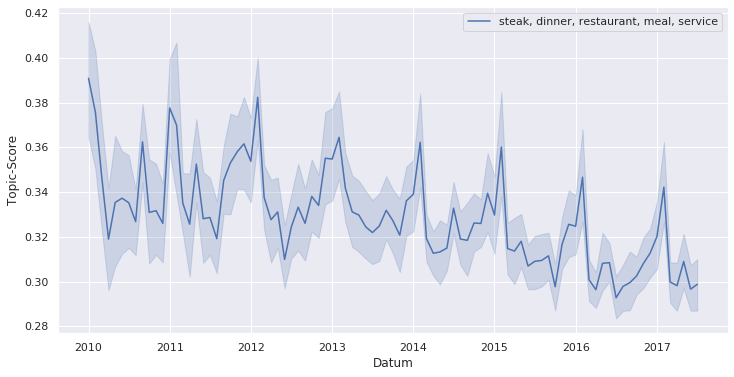

In [0]:
plt_traditional = plot_topics(tm_df_norm_stars, 3, lda=lda)
plt_traditional.figure.savefig("traditional.pdf", bbox_inches="tight")

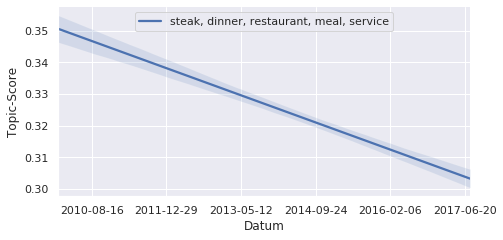

In [0]:
plt_traditional_reg = plot_topics_reg(tm_df_norm_stars, 3, lda=lda)
plt_traditional_reg.figure.savefig("traditional_reg.pdf", bbox_inches="tight")

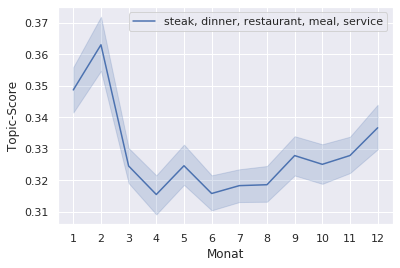

In [0]:
plt_traditional_months = plot_topics_per_month(tm_df_norm_stars, 3, lda=lda)
plt_traditional_months.figure.savefig("traditional_months.pdf", bbox_inches="tight")

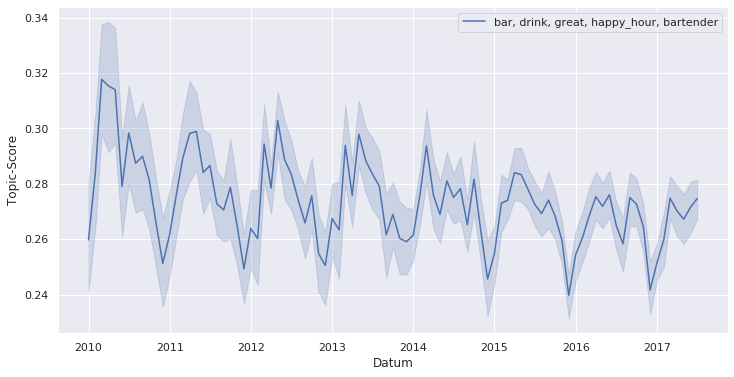

In [0]:
plt_bars = plot_topics(tm_df_norm_stars, 1, lda=lda)
plt_bars.figure.savefig("bars.pdf", bbox_inches="tight")

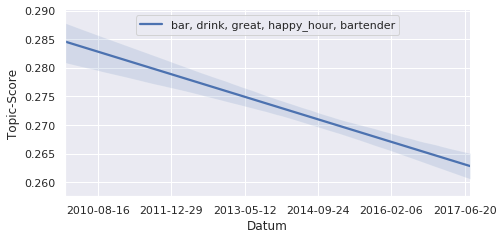

In [0]:
plot_topics_reg(tm_df_norm_stars, 1, lda=lda)

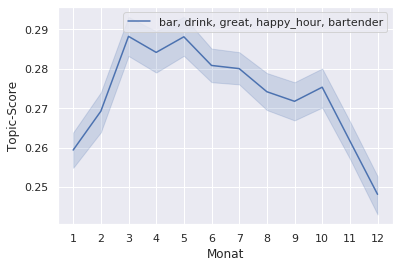

In [0]:
plt_bars_months = plot_topics_per_month(tm_df_norm_stars, 1, lda=lda)
plt_bars_months.figure.savefig("bars_months.pdf", bbox_inches="tight")

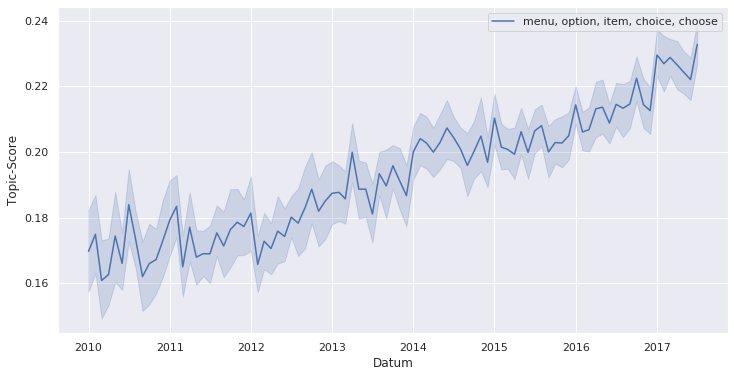

In [0]:
plt_menu_opts = plot_topics(tm_df_norm_stars, 0, lda=lda)
plt_menu_opts.figure.savefig("menu-opts.pdf", bbox_inches="tight")

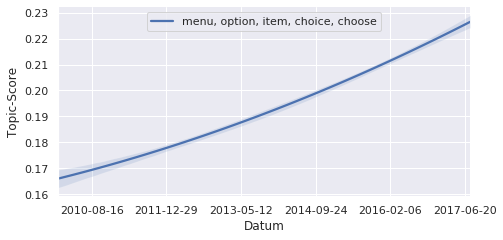

In [0]:
plt_menu_opts_reg = plot_topics_reg(tm_df_norm_stars, 0, lda=lda, order=2, robust=False)
plt_menu_opts_reg.figure.savefig("menu-opts_reg.pdf", bbox_inches="tight")

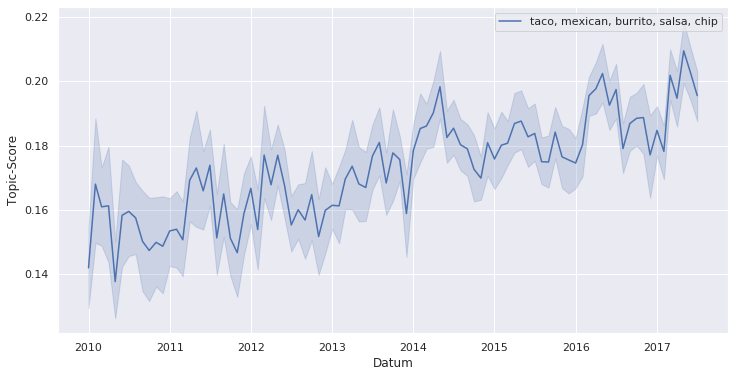

In [0]:
plt_mex = plot_topics(tm_df_norm_stars, 31, lda=lda)
plt_mex.figure.savefig("mex.pdf", bbox_inches="tight")

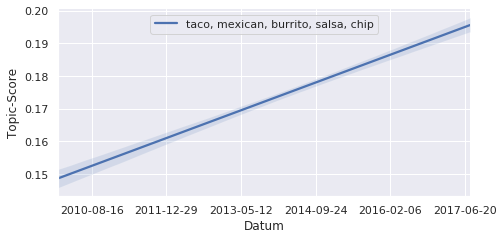

In [0]:
plt_mex_reg = plot_topics_reg(tm_df_norm_stars, 31, lda=lda)
plt_mex_reg.figure.savefig("mex_reg.pdf", bbox_inches="tight")

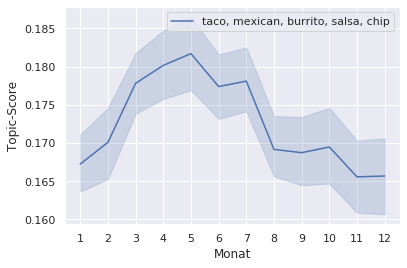

In [0]:
plt_mex_months = plot_topics_per_month(tm_df_norm_stars, 31, lda=lda)
plt_mex_months.figure.savefig("mex_months.pdf", bbox_inches="tight")

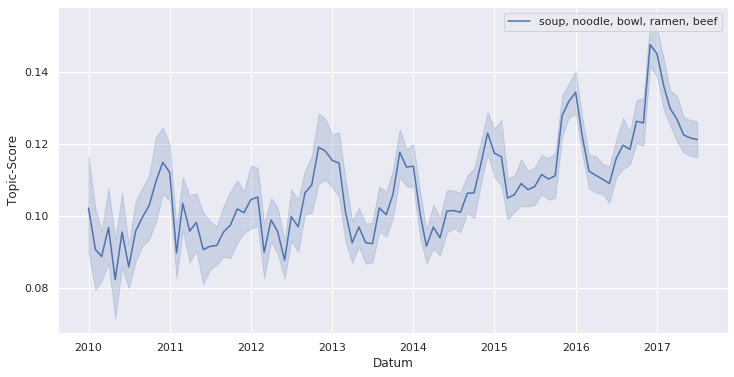

In [0]:
plt_asia_soup = plot_topics(tm_df_norm_stars, 25, lda=lda)
plt_asia_soup.figure.savefig("asia-soup.pdf", bbox_inches="tight")

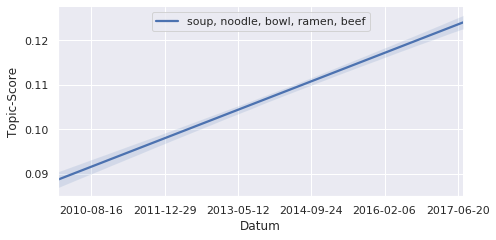

In [0]:
plt_asia_soup_reg = plot_topics_reg(tm_df_norm_stars, 25, lda=lda)
plt_asia_soup.figure.savefig("asia-soup_reg.pdf", bbox_inches="tight")

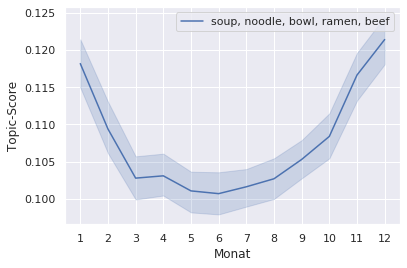

In [0]:
plt_asia_soup_months = plot_topics_per_month(tm_df_norm_stars, 25, lda=lda)
plt_asia_soup_months.figure.savefig("asia-soup_months.pdf", bbox_inches="tight")

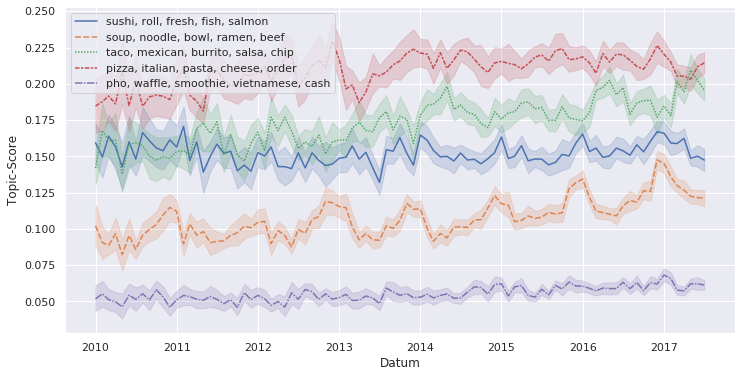

In [0]:
plt_ethnic = plot_topics(tm_df_norm_stars, 5, 25, 31, 35, 39, lda=lda)
plt_ethnic.figure.savefig("ethnic.pdf", bbox_inches="tight")

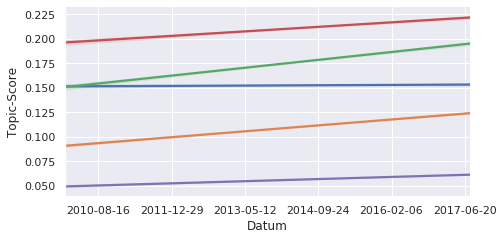

In [0]:
plt_ethnic_reg = plot_topics_reg(tm_df_norm_stars, 5, 25, 31, 35, 39, lda=lda, robust=False, legend_loc=None)
plt_ethnic_reg.figure.savefig("ethnic_reg.pdf", bbox_inches="tight")

## Reiteration des Modells

Wir "zoomen" in ein Topic in dem wir das Modell auf einen Teilbereich wiederanwenden.

In [0]:
class TopicAnalyzer:
    """Topic analyzer for easy topic model application and trend visualization."""

    def __init__(self, df, name):
        self.df = df

        self.name = name.lower()

        if not os.path.exists(p(self.name)):
            os.makedirs(p(self.name))

        self.dict = self.bow = self.lda = self.ldavis = None
        self.valid_topics = None
        self.tm = self.tm_norm = self.tm_norm_stars = None

    @classmethod
    def from_category_filter(cls, df, *, categories, categories_df=None):
        """Initialize the trend analyzer by filtering business reviews using yelp categories."""

        if len(categories) < 0:
            raise ValueError("Min. 1 category required")

        if not categories_df:
            cdf = load_table("category")
        else:
            cdf = categories_df

        if len(categories) == 1:
            mask = cdf.category == categories[0]
        else:
            mask = cdf.category.isin(categories)
        
        business_ids = cdf[mask].business_id.drop_duplicates()
        name = "_".join(map(str.lower, categories))

        return cls.from_business_filter(df, business_ids=business_ids.tolist(), name=name)

    @classmethod
    def from_business_filter(cls, df, *, business_ids, name):
        """Initialize the trend analyzer by filtering specified business ids."""

        df = df[df.business_id.isin(business_ids)]

        return cls(df, name)

    @classmethod
    def from_review_filter(cls, df, *, review_ids, name):
        df = df[df.index.isin(review_ids)]

        return cls(df, name)

    def get_dict(self, *, overwrite=False, no_below=20, no_above=0.7):
        """Create or load the dictionary."""

        if self.dict is None or overwrite:
            self.dict = get_dictionary(
                p(self.name, "dictionary.dict"),
                sentences=review_sentences(self.df),
                no_below=no_below,
                no_above=no_above,
                overwrite=overwrite
            )

        return self.dict

    def get_bow(self, *, overwrite=False):
        """Create or load the bag-of-words model."""

        if self.bow is None or overwrite:
            self.bow = get_bow(
                p(self.name, "bow.mm"),
                sentences=review_sentences(self.df),
                dictionary=self.get_dict(),
                overwrite=overwrite
            )

        return self.bow

    def get_lda(self, *, num_topics=15, passes=10, overwrite=False):
        """Create or load the LDA model."""

        if self.lda is None or overwrite:
            self.lda = get_lda(
                p(self.name, "lda"),
                bow=self.get_bow(),
                dictionary=self.get_dict(),
                chunksize=500,
                num_topics=num_topics,
                passes=passes,
                overwrite=overwrite
            )

        return self.lda

    def get_ldavis(self, *, overwrite=False, **kwargs):
        """Create or load the LDAvis html file."""

        return get_ldavis(
            p(self.name, "ldavis.html"),
            lda=self.get_lda(**kwargs),
            bow=self.get_bow(),
            dictionary=self.get_dict(),
            overwrite=overwrite
        )

    def set_valid_topics(self, topic_ids):
        """Specify the topic ids to be uses in the topic matrix."""

        self.valid_topics = topic_ids

    def get_tm(self, *, overwrite=False):
        """Create or load the topic matrix."""

        if self.tm is None or overwrite:
            self.tm = get_topics_matrix(
                p(self.name, "tm.parquet"),
                df=self.df,
                lda=self.get_lda(),
                dictionary=self.get_dict(),
                valid_topics=self.valid_topics,
                overwrite=overwrite
            )

        return self.tm

    def get_tm_norm(self, *, overwrite=False):
        """Create or load the normalized topic matrix."""

        if self.tm_norm is None or overwrite:
            self.tm_norm = get_topics_matrix_norm(
                p(self.name, "tm_norm.parquet"),
                df=self.df,
                topics_matrix=self.get_tm(overwrite=overwrite),
                overwrite=overwrite
            )

        return self.tm_norm

    def get_tm_norm_stars(self, *, overwrite=False):
        """Create or load the rating-weighted topic matrix."""

        if self.tm_norm_stars is None or overwrite:
            self.tm_norm_stars = get_topics_matrix_norm_stars(
                p(self.name, "tm_norm_stars.parquet"),
                df=self.df,
                topics_matrix_norm=self.get_tm_norm(overwrite=overwrite),
                overwrite=overwrite
            )

        return self.tm_norm_stars

    def plot(self, *topic_ids, stars=True):
        """Plot specified topics."""

        if stars:
            tm_df = self.get_tm_norm_stars()
        else:
            tm_df = self.get_tm_norm()

        return plot_topics(self.get_tm_norm_stars(), *topic_ids, lda=self.get_lda())

    def plot_months(self, *topic_ids, stars=True):
        """Plot topics per month."""

        if stars:
            tm_df = self.get_tm_norm_stars()
        else:
            tm_df = self.get_tm_norm()

        return plot_topics_per_month(self.get_tm_norm_stars(), *topic_ids, lda=self.get_lda())

    def plot_reg(self, *topic_ids, stars=True, **kwargs):
        """Plot regression of topics."""

        if stars:
            tm_df = self.get_tm_norm_stars()
        else:
            tm_df = self.get_tm_norm()

        return plot_topics_reg(self.get_tm_norm_stars(), *topic_ids, lda=self.get_lda(), **kwargs)

    @classmethod
    def remove(cls, name):
        shutil.rmtree(p(name.lower()))

In [0]:
def max_topic_score_reviews(topic_matrix, *topic_ids):
    """
    Returns all review ids for which the column of the
    max value is one of the specified topic ids.
    """

    tm = topic_matrix.drop(["date"], axis=1)
    return tm[
        tm.idxmax(axis=1).isin(map(str, topic_ids))
    ].index

In [0]:
# coffee, yoghurt, ice
coffee_review_ids = max_topic_score_reviews(tm_df_norm, 15)

In [0]:
coff = TopicAnalyzer.from_review_filter(en_revs_df, review_ids=coffee_review_ids, name="coffee")

In [0]:
coff.get_ldavis(num_topics=25, passes=30)

Lade '/gdrive/My Drive/yelp_data/coffee/dictionary.dict'...
Lade '/gdrive/My Drive/yelp_data/coffee/bow.mm'...
Lade '/gdrive/My Drive/yelp_data/coffee/lda'...
Lade '/gdrive/My Drive/yelp_data/coffee/ldavis.html'...


In [0]:
coff.set_valid_topics([0, 1, 7, 9, 11, 12, 21])

Lade '/gdrive/My Drive/yelp_data/coffee/tm.parquet'...
Lade '/gdrive/My Drive/yelp_data/coffee/tm_norm.parquet'...
Lade '/gdrive/My Drive/yelp_data/coffee/tm_norm_stars.parquet'...


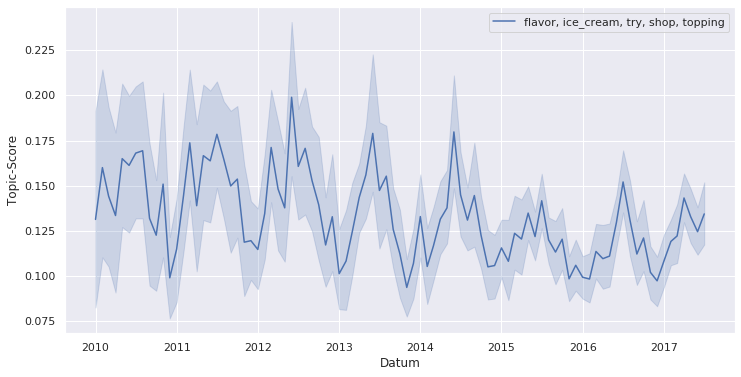

In [0]:
plt_ice = coff.plot(12)
plt_ice.figure.savefig("ice.pdf", bbox_inches="tight")

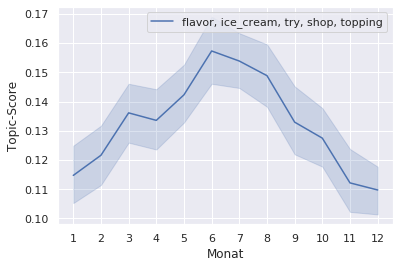

In [0]:
plt_ice_months = coff.plot_months(12)
plt_ice_months.figure.savefig("ice_months.pdf", bbox_inches="tight")

In [0]:
mex_review_ids = max_topic_score_reviews(tm_df_norm, 31)

In [0]:
mex = TopicAnalyzer.from_review_filter(en_revs_df, review_ids=mex_review_ids, name="mex")

In [0]:
mex.get_ldavis(num_topics=30, passes=30)

Lade '/gdrive/My Drive/yelp_data/mex/dictionary.dict'...
Lade '/gdrive/My Drive/yelp_data/mex/bow.mm'...
Lade '/gdrive/My Drive/yelp_data/mex/lda'...
Lade '/gdrive/My Drive/yelp_data/mex/ldavis.html'...


In [0]:
mex.set_valid_topics([0, 5, 6, 8, 12, 14, 16, 17, 18, 19, 20, 22, 25, 26, 28])

Lade '/gdrive/My Drive/yelp_data/mex/tm.parquet'...
Lade '/gdrive/My Drive/yelp_data/mex/tm_norm.parquet'...
Lade '/gdrive/My Drive/yelp_data/mex/tm_norm_stars.parquet'...


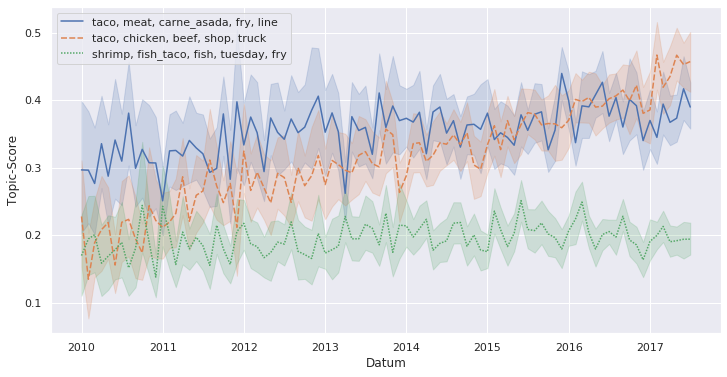

In [0]:
plt_mex_tacos = mex.plot(18, 26, 28)
plt_mex_tacos.figure.savefig("mex-tacos_comp.pdf", bbox_inches="tight")

In [0]:
# soup ramen ... topic 25
# pho vietnamese topic 39

In [0]:
asian_soup_review_ids = max_topic_score_reviews(tm_df_norm, 25, 39)

In [0]:
soup = TopicAnalyzer.from_review_filter(en_revs_df, review_ids=asian_soup_review_ids, name="asian_soup")

In [0]:
soup.get_ldavis(num_topics=30, passes=40)

Lade '/gdrive/My Drive/yelp_data/asian_soup/dictionary.dict'...
Lade '/gdrive/My Drive/yelp_data/asian_soup/bow.mm'...
Lade '/gdrive/My Drive/yelp_data/asian_soup/lda'...
Lade '/gdrive/My Drive/yelp_data/asian_soup/ldavis.html'...


In [0]:
soup.set_valid_topics([2, 25, 26])

Lade '/gdrive/My Drive/yelp_data/asian_soup/tm.parquet'...
Lade '/gdrive/My Drive/yelp_data/asian_soup/tm_norm.parquet'...
Lade '/gdrive/My Drive/yelp_data/asian_soup/tm_norm_stars.parquet'...


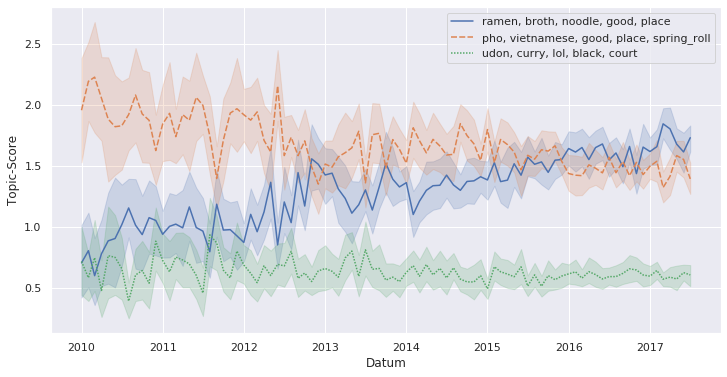

In [0]:
plt_asia_soups = soup.plot(2, 25, 26)
plt_asia_soups.figure.savefig("asia-soup_comp.pdf", bbox_inches="tight")

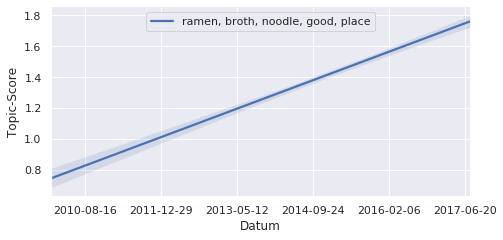

In [0]:
soup.plot_reg(2)

# Plots

In [0]:
sns.reset_orig()

In [0]:
def normalization_steps(doc):
    """Count the text lenght after every text normalization step."""

    def len_(sents):
        return sum(map(lambda s: sum(map(len, s)), sents))

    doc_len = len_(doc.sents)

    pct_len = len_(normalize_document(
        doc,
        check_is_punct
    ))
    spc_len = len_(normalize_document(
        doc,
        check_is_punct, check_is_special
    ))
    stp_len = len_(normalize_document(
        doc,
        check_is_punct, check_is_special, check_is_stop
    ))
    lmm_len = len_(normalize_document(
        doc,
        check_is_punct, check_is_special, check_is_stop,
        token_transformer=to_lemma
    ))

    return pd.Series({
        "Original-Text": doc_len,
        "Interpunktion\nentfernen": pct_len,
        "Zahlen u. Sonderzeichen\nentfernen": spc_len,
        "Stop-Words\nentfernen": stp_len,
        "Lemmatisierung": lmm_len
    })

In [0]:
def plot_normalization_progress(n=5_000):
    """Plot the normalization progress for specified sample size."""

    nlp = load_spacy_model()

    df_sample = df[["text"]].sample(n=n, random_state=SEED)

    df_sample_progress = df_sample.merge(
        df_sample.text.progress_apply(lambda text: normalization_steps(nlp(text))),
        left_index=True,
        right_index=True
    )

    progress_mean = df_sample_progress.drop(["text"], axis=1).apply(np.mean)

    progress_plot = progress_mean.plot(linestyle='--', marker='o', color="k", figsize=(8.55, 3.795))

    ymin, ymax = progress_plot.get_ylim()
    perc = lambda value: 100*value/progress_mean.max()

    ax2 = progress_plot.secondary_yaxis("right", functions=(perc, perc))
    ax2.set_ylabel("% Textlänge")

    progress_plot.set_ylabel("Ø Textlänge")
    progress_plot.xaxis.set_tick_params(which="both", bottom=False, top=False)

    return progress_plot, progress_mean

     |████████████████████████████▏   | 728.9MB 76.4MB/s eta 0:00:02

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



     |████████████████████████████████| 826.9MB 76.4MB/s 
  Created wheel for en-core-web-lg: filename=en_core_web_lg-2.1.0-cp36-none-any.whl size=828255078 sha256=7cba6dd68e6eaa1ad9e3a7176f63458e8b3bb91ed1544d0513a3cac382096c64
  Stored in directory: /tmp/pip-ephem-wheel-cache-al8898n7/wheels/b4/d7/70/426d313a459f82ed5e06cc36a50e2bb2f0ec5cb31d8e0bdf09
Successfully built en-core-web-lg
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')



Durschnittliche Gesamtreduktion der Review-Textlänge: 46.48%


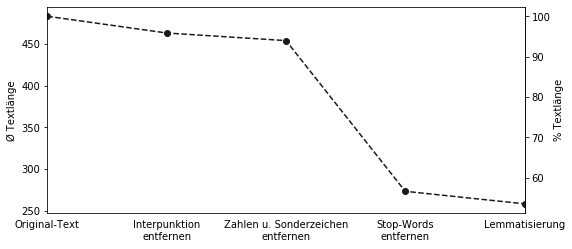

In [0]:
progress_plot, progress_df = plot_normalization_progress()
progress_plot.figure.savefig("food-rev-normalization-progress.pdf", bbox_inches="tight")

total_percent_decrease = 100 * (1 - progress_df['Lemmatisierung']/progress_df['Original-Text'])
print(f"Durschnittliche Gesamtreduktion der Review-Textlänge: {total_percent_decrease:.2f}%")

In [0]:
def plot_language_distribution(langs):
    """Plot the distribution of languages of the dataset."""

    !pip install iso-639
    from iso639 import languages

    langs = langs.groupby(langs).size()

    def language_name(language_code):
        if language_code == "UNKNOWN":
            return "N/A"
        else:
            if "-" in language_code:
                language_code = language_code.split("-")[0]
            
            return languages.get(alpha2=language_code).name

    langs.index = langs.index.map(language_name)
    langs = langs.groupby(langs.index).sum()

    langs_plot = langs.sort_values(ascending=False).head(10).plot.bar(logy=True, color="k")
    # langs_plot.set_title("Reviewanzahl nach Sprache")
    langs_plot.set_xlabel("")
    langs_plot.set_ylabel("log(|Reviews|)")

    return langs_plot

     |████████████████████████████████| 174kB 2.7MB/s 
  Created wheel for iso-639: filename=iso_639-0.4.5-cp36-none-any.whl size=169062 sha256=b174946fca7165eaa5fc3e2dda6f4e77887cf44800223fba05066ce135a817a3
  Stored in directory: /root/.cache/pip/wheels/52/60/07/73aed7d23ae9b5729970632922ed5e45b535bcd4b8df77ebe9
Successfully built iso-639


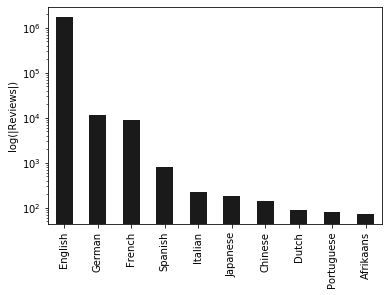

In [0]:
langs_plot = plot_language_distribution(df.language)
langs_plot.figure.savefig("food-rev-language-distribution.pdf", bbox_inches="tight")

the 1465427
and 901466
to 594030
was 490428
it 466968
of 450609
is 346681
for 322709
in 310292
that 257731
but 246667
with 243289
you 229913
we 226319
my 217909


Text(0, 0.5, 'Anzahl Vorkommen')

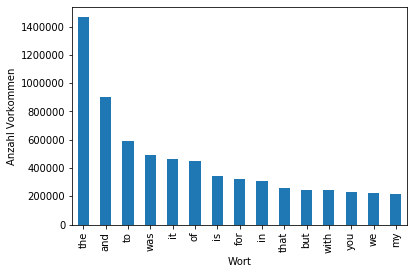

In [0]:
#Quelle: https://towardsdatascience.com/a-complete-exploratory-data-analysis-and-visualization-for-text-data-29fb1b96fb6a

def top15_with_sw(corpus):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:15]
df_with_sw = df.drop(df.index[200000:])
common_words_with_sw = top15_with_sw(df_with_sw['text'])
for word, freq in common_words_with_sw:
    print(word, freq)
df_with_sw1 = pd.DataFrame(common_words_with_sw, columns = ['text' , 'count'])
with_sw = df_with_sw1.groupby('text').sum()['count'].sort_values(ascending=False).plot(
    kind='bar')
with_sw.set_xlabel("Wort")
with_sw.set_ylabel("Anzahl Vorkommen")

In [0]:
with_sw.figure.savefig("count_with_sw.pdf", bbox_inches="tight")

food 159381
good 157974
place 139981
like 105177
great 96170
just 95631
service 76341
really 74385
time 69059
restaurant 54441
ve 53825
ordered 49434
menu 48423
don 47316
chicken 46611


Text(0, 0.5, 'Anzahl Vorkommen')

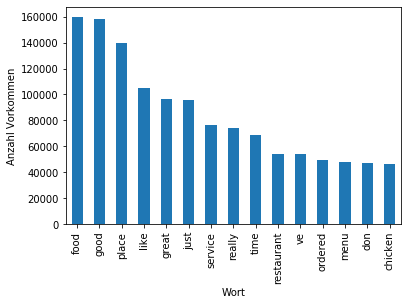

In [0]:
#Quelle: https://towardsdatascience.com/a-complete-exploratory-data-analysis-and-visualization-for-text-data-29fb1b96fb6a

def top15_without_sw(corpus):
    vec = CountVectorizer(stop_words = 'english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:15]
df_without_sw = df.drop(df.index[200000:])
common_words_without_sw = top15_without_sw(df_without_sw['text'])
for word, freq in common_words_without_sw:
    print(word, freq)
df_without_sw1 = pd.DataFrame(common_words_without_sw, columns = ['text' , 'count'])
without_sw = df_without_sw1.groupby('text').sum()['count'].sort_values(ascending=False).plot(
    kind='bar')
without_sw.set_xlabel("Wort")
without_sw.set_ylabel("Anzahl Vorkommen")

In [0]:
without_sw.figure.savefig("count_without_sw.pdf", bbox_inches="tight")

In [0]:
!zip ./graphs.zip ./*.pdf

updating: asia-soup_comp.pdf (deflated 21%)
updating: asia-soup_months.pdf (deflated 31%)
updating: asia-soup.pdf (deflated 27%)
updating: asia-soup_reg.pdf (deflated 27%)
updating: bars_months.pdf (deflated 31%)
updating: bars.pdf (deflated 27%)
updating: ethnic.pdf (deflated 18%)
updating: ethnic_reg.pdf (deflated 15%)
updating: food-rev-language-distribution.pdf (deflated 31%)
updating: food-rev-normalization-progress.pdf (deflated 32%)
updating: ice_months.pdf (deflated 32%)
updating: ice.pdf (deflated 28%)
updating: menu-opts.pdf (deflated 26%)
updating: menu-opts_reg.pdf (deflated 26%)
updating: mex_months.pdf (deflated 31%)
updating: mex.pdf (deflated 27%)
updating: mex_reg.pdf (deflated 26%)
updating: mex-tacos_comp.pdf (deflated 21%)
updating: traditional_months.pdf (deflated 32%)
updating: traditional.pdf (deflated 27%)
updating: traditional_reg.pdf (deflated 26%)
  adding: count_without_sw.pdf (deflated 32%)
  adding: count_with_sw.pdf (deflated 33%)
